# 1. Neural Networks: MNIST image classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

MAX_POOL_SIZE = 5
CONVOLUTION_SIZE = 4
CONVOLUTION_FILTERS = 2

## (a)

Debug function for testing backwards propagation:

In [2]:
def test_grad(fwd, bwd, x, needs_grad_out=True):
    """
    tests if bwd correctly computes the gradient of fwd at x
    args:
        fwd: forward function
        bwd: backward function
        x: point at which to evaluate the gradient of fwd
        needs_grad_out: how is bwd called? bwd(x, grad_out) or bwd(x)
    """
    cost = lambda y: np.sum(fwd(y)**2)
    if needs_grad_out:
        grad_out = 2*fwd(x)
        grad_x = bwd(x, grad_out)
    else:
        grad_x = bwd(x)
        
    h= 1e-6
    for i,xi in np.ndenumerate(x):
        xp = np.copy(x)
        xp[i] = xi+h
        xm = np.copy(x)
        xm[i] = xi-h
        if needs_grad_out:
            num_grad = (cost(xp)-cost(xm))/(2*h)
        else:
            num_grad = (fwd(xp)-fwd(xm))/(2*h)
        
        error = grad_x[i] - num_grad
        if abs(error) > 1e-5:
            print("test failed")
            print("grad_x", grad_x)
            print("grad_x[i]", grad_x[i])
            print("num_grad", num_grad)
            return
    print("test passed")

**i. backward_softmax**

Forward function:

In [3]:
def forward_softmax(x):
    """
    Compute softmax function for a single example.
    The shape of the input is of size # num classes.

    Important Note: You must be careful to avoid overflow for this function. Functions
    like softmax have a tendency to overflow when very large numbers like e^10000 are computed.
    You will know that your function is overflow resistent when it can handle input like:
    np.array([[10000, 10010, 10]]) without issues.

    Args:
        x: A 1d numpy float array of shape number_of_classes

    Returns:
        A 1d numpy float array containing the softmax results of shape  number_of_classes
    """
    x = x - np.max(x,axis=0)
    exp = np.exp(x)
    s = exp / np.sum(exp,axis=0)
    return s

For a vector $x$ we have 
$$ \text{softmax}(x) = \frac{\exp(x)}{\sum_{k}\exp(x_k)}. $$

A straightforward calculation shows 
$$ \frac{\partial}{\partial x_i}\frac{\exp(x_j)}{\sum_{k}x_k} = \begin{cases}\frac{\exp(x_j)}{\sum_{k}\exp(x_k)}\left(1-\frac{\exp(x_j)}{\sum_{k}\exp(x_k)}\right) &\text{if } i=j,\\
-\frac{\exp(x_j)}{\sum_{k}\exp(x_k)}\frac{\exp(x_i)}{\sum_{k}\exp(x_k)} &\text{otherwise.}\end{cases}$$

Therefore the Jacobian is given by the (symmetric) matrix
$$ \mathrm d_x \text{softmax}(x) = \mathrm{diag}(\text{softmax}(x) )- \text{softmax}(x)\left(\text{softmax}(x)\right)^T$$

Hence by the chainrule
$$\begin{align*} 
\nabla_x \text{loss} &=\left(\mathrm{diag}(\text{softmax}(x) )- \text{softmax}(x)\left(\text{softmax}(x)\right)^T\right)\left(\nabla_\text{softmax(x)} \text{loss}\right)\\  
&= \text{softmax}(x) \odot \nabla_\text{softmax(x)} \text{loss} - \text{softmax}(x)\left(\text{softmax}(x)^T\nabla_\text{softmax(x)}\text{loss}\right) ,
\end{align*}$$
where $\odot$ is the Hadamard product (i.e. elementwise multiplication).

In [4]:
def backward_softmax(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x.

    grad_outputs is the gradient of the loss with respect to the outputs of the softmax.

    Args:
        x: A 1d numpy float array of shape number_of_classes
        grad_outputs: A 1d numpy flaot array of shape number_of_classes 

    Returns:
        A 1d numpy float array of the same shape as x with the derivative of the loss with respect to x
    """
    
    # *** START CODE HERE ***
    s = forward_softmax(x)
    return s*grad_outputs  - s * np.dot(s, grad_outputs)
    # *** END CODE HERE ***

Test it:

In [5]:
x = 20*np.random.random_sample(size=10)-10
test_grad(forward_softmax, backward_softmax,x)

test passed


**ii. backward_relu**

In [6]:
def forward_relu(x):
    """
    Compute the relu function for the input x.

    Args:
        x: A numpy float array

    Returns:
        A numpy float array containing the relu results
    """

    x[x<=0] = 0

    return x

As 
$$ \text{ReLu}(x) = \max\{0,x\}$$
we have
$$ \mathrm d_x \text{ReLu}(x) = \mathrm{diag}\left(1\{x_1>0\}, \ldots,1\{x_n>0\}\right) $$

and therefore
$$ \nabla_x \text{loss} = \left(1\{x_1>0\}, \ldots,1\{x_n>0\}\right)^T \odot \nabla_{\text{ReLu}(x)} \text{loss}.$$

In [7]:
def backward_relu(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x

    Args:
        x: A numpy array of arbitrary shape containing the input.
        grad_outputs: A numpy array of the same shape of x containing the gradient of the loss with respect
            to the output of relu

    Returns:
        A numpy array of the same shape as x containing the gradients with respect to x.
    """
    # *** START CODE HERE ***
    return  (x > 0) * grad_outputs
    # *** END CODE HERE ***


Test it:

In [8]:
x = 20*np.random.sample(size=10) -10
test_grad(forward_relu, backward_relu,x)

test passed


**iii. backward_cross_entropy_loss**

In [9]:
def forward_cross_entropy_loss(probabilities, labels):
    """
    Compute the output from a cross entropy loss layer given the probabilities and labels.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be a scalar

    Returns:
        The result of the log loss layer
    """

    result = 0

    for i, label in enumerate(labels):
        if label == 1:
            result += -np.log(probabilities[i])

    return result

From 
$$CE(prob, label) = -\sum_{k=1}^K label_k \log prob_k = - label^T \log prob$$
we get 
$$ \nabla_{prob} CE(prob, label) = - label \odot \left(\frac 1{prob_1},\ldots, \frac 1{prob_K}\right)^T.$$

In [10]:
def backward_cross_entropy_loss(probabilities, labels):
    """
    Compute the gradient of the cross entropy loss with respect to the probabilities.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be the gradient with respect to the probabilities.

    Returns:
        The gradient of the loss with respect to the probabilities.
    """

    # *** START CODE HERE ***
    return - labels / probabilities
    # *** END CODE HERE ***


Test it:

In [11]:
labels = np.zeros(10)
probs = np.random.sample(10)
i = np.random.randint(10)
labels[i]=1
fwd = lambda x: forward_cross_entropy_loss(x,labels)
bwd = lambda x: backward_cross_entropy_loss(x,labels)
test_grad(fwd, bwd, probs, needs_grad_out=False)

test passed


**iv. backward_linear**

In [12]:
def forward_linear(weights, bias, data):
    """
    Compute the output from a linear layer with the given weights, bias and data.
    weights is of the shape (input # features, output # features)
    bias is of the shape (output # features)
    data is of the shape (input # features)

    The output should be of the shape (output # features)

    Returns:
        The result of the linear layer
    """

    return data.dot(weights) + bias


If we denote weights, bias, data as $W,b,x$ (where $b,x$ are column vectors), then the forward_linear function has the output $W^Tx + b$.

We have 
$$ \mathrm d_x (W^Tx+b) = W^T$$
and 
$$ \mathrm d_b (W^Tx+b) = I.$$

Therefore 
$$ \nabla_x \text{loss} = W \nabla_{W^Tx+b} \text{loss}$$
and 
$$ \nabla_b \text{loss} = \nabla_{W^Tx+b} \text{loss}.$$

For a matrix $V$ of the same shape as $W$ we have
$$\begin{align*}
\mathrm d_W (W^Tx+b)V &= V^Tx
\end{align*}$$

Therefore
$$\begin{align*}
\mathrm d_W (\text{loss})V &= \mathrm d_{W^Tx+b} (\text{loss})V^Tx\\
&= \mathrm{tr}\left(\mathrm d_{W^Tx+b} (\text{loss})V^Tx\right)\\
&= \mathrm{tr}\left(V^Tx\mathrm d_{W^Tx+b} (\text{loss})\right).
\end{align*}$$

Hence
$$\nabla_W(\text{loss}) = x\mathrm d_{W^Tx+b} (\text{loss}) = x\left(\nabla_{W^Tx+b} (\text{loss})\right)^T$$
(Check my notes to the gradient in problem set 0, if this doesn't make sense to you.)

In [13]:
def backward_linear(weights, bias, data, output_grad):
    """
    Compute the gradients of the loss with respect to the parameters of a linear layer.

    See forward_linear for information about the shapes of the variables.

    output_grad is the gradient of the loss with respect to the output of this layer.

    This should return a tuple with three elements:
    - The gradient of the loss with respect to the weights
    - The gradient of the loss with respect to the bias
    - The gradient of the loss with respect to the data
    """

    # *** START CODE HERE ***
    grad_data = weights @ output_grad 
    grad_weights = data[..., np.newaxis] @ output_grad.reshape((1,-1))
    grad_bias = output_grad
    
    return grad_weights, grad_bias, grad_data
    # *** END CODE HERE ***

Test backward_linear with random inputs:

In [14]:
weights = 4*np.random.sample((50,10))-2
bias = 4*np.random.sample(10)-2
data = 4*np.random.sample(50)-2
fwd_w = lambda w: forward_linear(w, bias, data)
bwd_w = lambda w, output_grad: backward_linear(w,bias, data, output_grad)[0]
print("weights:")
test_grad(fwd_w,bwd_w,weights)

fwd_b = lambda b: forward_linear(weights, b, data)
bwd_b = lambda b, output_grad: backward_linear(weights,b, data, output_grad)[1]
print("bias:")
test_grad(fwd_b,bwd_b,bias)

fwd_d = lambda d: forward_linear(weights, bias, d)
bwd_d = lambda d, output_grad: backward_linear(weights,bias, d, output_grad)[2]
print("data:")
test_grad(fwd_d,bwd_d,data)

weights:
test passed
bias:
test passed
data:
test passed


**v. backward_convolution**

In [15]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """

    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]

    return output

Let's abbreviate output,out_channel, convolution_bias, convolution_weights, in_channel by $out, oc, c_b, c_W, ic$ and convolution_width, convolution_height, input_width, input_height by $c_w,c_h, i_w,i_h$.

Then
$$ out[oc,x,y] = c_b[oc] + \sum_{di,dj,ic} data[ic, x+di,y+dj] \cdot c_W[oc, ic, di,dj].$$

So
$$\begin{align*} 
\frac{\partial out[oc,x,y]}{\partial c_W[oc',ic,di,dj]} &= \begin{cases}
0 & \text{if } oc\not= oc',\\
data[ic, x+di,y+dj] &\text{if } oc = oc',
\end{cases}\\
\end{align*}$$

$$\frac{\partial out[oc,x,y]}{\partial c_b[oc']} = 1\{oc=oc'\}, $$

and
$$ \frac{\partial out[oc,x,y]}{\partial data[ic,x',y']} = \begin{cases}
c_W[oc,ic,x'-x,y'-y] &\text{if } 0\leq x'-x< c_w \land 0\leq y'-y< c_h,\\
0 &\text{otherwise}.
\end{cases}$$

Therefore 
$$\frac{\partial \text{loss}}{\partial c_W[oc,ic,di,dj]} = \sum_{x,y}\frac{\partial \text{loss}}{\partial out[oc,x,y]}data[ic,x+d_i,y+d_j],$$

$$\frac{\partial \text{loss}}{\partial c_b[oc]} = \sum_{x,y}\frac{\partial \text{loss}}{\partial out[oc,x,y]},$$
where in both cases $0\leq x \leq i_w-c_w$ and $0\leq y \leq i_h-c_h$.

Lastly
$$\frac{\partial \text{loss}}{\partial data[ic,x',y']} = \sum_{oc,x,y} \frac{\partial \text{loss}}{\partial out[oc,x,y]}c_W[oc,ic,x'-x,y'-y]$$
where again $0\leq x \leq i_w-c_w$ and $0\leq y \leq i_h-c_h$, but also $x'-c_w+1\leq x\leq x'$ and $y'-c_h+1\leq y\leq y'$.

In [16]:
def backward_convolution(conv_W, conv_b, data, output_grad):
    """
    Compute the gradient of the loss with respect to the parameters of the convolution.

    See forward_convolution for the sizes of the arguments.
    output_grad is the gradient of the loss with respect to the output of the convolution.

    Returns:
        A tuple containing 3 gradients.
        The first element is the gradient of the loss with respect to the convolution weights
        The second element is the gradient of the loss with respect to the convolution bias
        The third element is the gradient of the loss with respect to the input data
    """

    # *** START CODE HERE ***
    conv_W_grad = np.zeros(conv_W.shape)
    data_grad = np.zeros(data.shape)
    
    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape
    
    conv_b_grad = np.sum(output_grad, axis=(1,2))
    
    for di in range(conv_width):
        for dj in range(conv_height):
            conv_W_grad[:,:,di,dj] = np.sum(output_grad.reshape((conv_channels,1,input_width-conv_width+1,input_height-conv_height+1)) * data[:,di:di+input_width-conv_width+1,dj:dj+input_height-conv_height+1], axis=(-2,-1))
    
    for x_ in range(input_width):
        xmin = np.max([0, x_-conv_width+1])
        xmax = np.min([input_width-conv_width, x_])
        for y_ in range(input_height):
            ymin = np.max([0, y_-conv_height+1])
            ymax = np.min([input_height-conv_height, y_])            
            
            for x in range(xmin, xmax+1):
                for y in range(ymin, ymax+1):
                    data_grad[:,x_,y_]+=np.sum(output_grad[:,x,y][...,np.newaxis]*conv_W[:,:,x_-x,y_-y], axis=0)
    
    return conv_W_grad, conv_b_grad, data_grad            
    # *** END CODE HERE ***

Test it (the data test takes a bit):

In [17]:
conv_W = 4*np.random.sample((2,1,4,4))-2
conv_b = 4*np.random.sample(2)-2
data = 4*np.random.sample((1,28,28))-2

fwd_w = lambda w: forward_convolution(w, conv_b, data)
bwd_w = lambda w, output_grad: backward_convolution(w,conv_b, data, output_grad)[0]
print("weights:")
test_grad(fwd_w,bwd_w,conv_W)

fwd_b = lambda b: forward_convolution(conv_W, b, data)
bwd_b = lambda b, output_grad: backward_convolution(conv_W,b, data, output_grad)[1]
print("bias:")
test_grad(fwd_b,bwd_b,conv_b)

fwd_d = lambda d: forward_convolution(conv_W, conv_b, d)
bwd_d = lambda d, output_grad: backward_convolution(conv_W,conv_b, d, output_grad)[2]
print("data:")
test_grad(fwd_d,bwd_d,data)

weights:
test passed
bias:
test passed
data:
test passed


**vi. backward_max_pool**

In [18]:
def forward_max_pool(data, pool_width, pool_height):
    """
    Compute the output from a max pooling layer given the data and pool dimensions.

    The stride length should be equal to the pool size

    data is of the shape (# channels, width, height)

    The output should be the result of the max pooling layer and should be of size:
        (# channels, width // pool_width, height // pool_height)

    Returns:
        The result of the max pooling layer
    """

    input_channels, input_width, input_height = data.shape

    output = np.zeros((input_channels, input_width // pool_width, input_height // pool_height))

    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):

            output[:, x // pool_width, y // pool_height] = np.amax(data[:, x:(x + pool_width), y:(y + pool_height)], axis=(1, 2))

    return output


With 
$$out[c,x,y] = \max_{di,dj} data[c, x\cdot p_w+di, y\cdot p_h+dj],$$
where $p_w,p_h$ are the pool width and height, we get

$$ \frac{\partial out[c,x,y]}{\partial data[c',x',y']}= 1$$
if $c=c'$ and $(x',y') = (xp_w+di^*, yp_h+dj^*)$ for 
$$ (di^*,dj^*) = \arg\max_{di,dj} data[c, x\cdot p_w+di, y\cdot p_h+dj].$$
Otherwise 
$$ \frac{\partial out[c,x,y]}{\partial data[c',x',y']}= 0$$

Therefore 
$$ \frac{\partial \text{loss}}{\partial data[c,x',y']}= \sum_{x,y} \frac{\partial \text{loss}}{\partial out[c,x,y]}$$
where the sum ranges over all $x,y$ such that $\frac{\partial out[c,x,y]}{\partial data[c,x',y']}= 1$.

In [19]:
def backward_max_pool(data, pool_width, pool_height, output_grad):
    """
    Compute the gradient of the loss with respect to the data in the max pooling layer.

    data is of the shape (# channels, width, height)
    output_grad is of shape (# channels, width // pool_width, height // pool_height)

    output_grad is the gradient of the loss with respect to the output of the backward max
    pool layer.

    Returns:
        The gradient of the loss with respect to the data (of same shape as data)
    """

    # *** START CODE HERE ***
    input_channels, input_width, input_height = data.shape
    output_width, output_height = output_grad.shape[1:]
    forw_data = forward_max_pool(data, pool_width, pool_height)
    
    data_grad = np.zeros(data.shape)
    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):
            for c in range(0,input_channels):
                pool = data[c, x:(x + pool_width), y:(y + pool_height)]
                argmax = np.argmax(pool)
                di,dj = np.unravel_index(argmax, pool.shape)
                data_grad[c,x+di,y+dj] += output_grad[c, x//pool_width, y//pool_height]
    
    return data_grad
    # *** END CODE HERE ***

Test it:

In [20]:
data = 10*np.random.sample((2,25,25))-5
pool_width = 5
pool_height = 5


fwd = lambda d: forward_max_pool(d, pool_width, pool_height)
bwd = lambda d, output_grad: backward_max_pool(d, pool_width, pool_height,output_grad)
print("data:")
test_grad(fwd,bwd,data)

data:
test passed


## (b) backward_prop

In [21]:
def forward_prop(data, labels, params):
    """
    Implement the forward layer given the data, labels, and params.
    
    Args:
        data: A numpy array containing the input (shape is 1 by 28 by 28)
        labels: A 1d numpy array containing the labels (shape is 10)
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A 2 element tuple containing:
            1. A numpy array The output (after the softmax) of the output layer
            2. The average loss for these data elements
    """

    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)

    flattened = np.reshape(first_after_relu, (-1))
   
    logits = forward_linear(W2, b2, flattened)

    y = forward_softmax(logits)
    cost = forward_cross_entropy_loss(y, labels)

    return y, cost


In [22]:
def backward_prop(data, labels, params):
    """
    Implement the backward propegation gradient computation step for a neural network
    
    Args:
        data: A numpy array containing the input for a single example
        labels: A 1d numpy array containing the labels for a single example
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2, and b2
            W1 and b1 represent the weights and bias for the convolutional layer
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.
        
        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    # *** START CODE HERE ***
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)

    flattened = np.reshape(first_after_relu, (-1))
   
    logits = forward_linear(W2, b2, flattened)

    y = forward_softmax(logits)
    cost = forward_cross_entropy_loss(y, labels)
    
    grad={}
    grad_y = backward_cross_entropy_loss(y, labels)
    grad_logits =backward_softmax(logits, grad_y)
    grad['W2'], grad['b2'], grad_flattened = backward_linear(W2, b2, flattened, grad_logits)

    grad_first_after_relu = grad_flattened.reshape(first_after_relu.shape)
    grad_first_max_pool = backward_relu(first_max_pool, grad_first_after_relu)
    grad_first_convolution = backward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE, grad_first_max_pool)
    grad['W1'], grad['b1'], grad_data = backward_convolution(W1, b1, data, grad_first_convolution)
    return grad
    # *** END CODE HERE ***

## Training the model

I left the following functions from the starter code unchanged: 

In [23]:
def get_initial_params():
    """
    Compute the initial parameters for the neural network.

    This function should return a dictionary mapping parameter names to numpy arrays containing
    the initial values for those parameters.

    There should be four parameters for this model:
    W1 is the weight matrix for the convolutional layer
    b1 is the bias vector for the convolutional layer
    W2 is the weight matrix for the output layers
    b2 is the bias vector for the output layer

    Weight matrices should be initialized with values drawn from a random normal distribution.
    The mean of that distribution should be 0.
    The variance of that distribution should be 1/sqrt(n) where n is the number of neurons that 
    feed into an output for that layer.

    Bias vectors should be initialized with zero.
    
    
    Returns:
        A dict mapping parameter names to numpy arrays
    """
  
    size_after_convolution = 28 - CONVOLUTION_SIZE + 1
    size_after_max_pooling = size_after_convolution // MAX_POOL_SIZE

    num_hidden = size_after_max_pooling * size_after_max_pooling * CONVOLUTION_FILTERS

    return {
        'W1': np.random.normal(size = (CONVOLUTION_FILTERS, 1, CONVOLUTION_SIZE, CONVOLUTION_SIZE), scale=1/ math.sqrt(CONVOLUTION_SIZE * CONVOLUTION_SIZE)),
        'b1': np.zeros(CONVOLUTION_FILTERS),
        'W2': np.random.normal(size = (num_hidden, 10), scale = 1/ math.sqrt(num_hidden)),
        'b2': np.zeros(10)
    }

In [24]:
def forward_prop_batch(batch_data, batch_labels, params, forward_prop_func):
    """Apply the forward prop func to every image in a batch"""

    y_array = []
    cost_array = []

    for item, label in zip(batch_data, batch_labels):
        y, cost = forward_prop_func(item, label, params)
        y_array.append(y)
        cost_array.append(cost)

    return np.array(y_array), np.array(cost_array)

In [25]:
def gradient_descent_batch(batch_data, batch_labels, learning_rate, params, backward_prop_func):
    """
    Perform one batch of gradient descent on the given training data using the provided learning rate.

    This code should update the parameters stored in params.
    It should not return anything

    Args:
        batch_data: A numpy array containing the training data for the batch
        train_labels: A numpy array containing the training labels for the batch
        learning_rate: The learning rate
        params: A dict of parameter names to parameter values that should be updated.
        backward_prop_func: A function that follows the backwards_prop API

    Returns: This function returns nothing.
    """

    total_grad = {}

    for i in range(batch_data.shape[0]):
        grad = backward_prop_func(
            batch_data[i, :, :], 
            batch_labels[i, :], 
            params)
        for key, value in grad.items():
            if key not in total_grad:
                total_grad[key] = np.zeros(value.shape)

            total_grad[key] += value

    params['W1'] = params['W1'] - learning_rate * total_grad['W1']
    params['W2'] = params['W2'] - learning_rate * total_grad['W2']
    params['b1'] = params['b1'] - learning_rate * total_grad['b1']
    params['b2'] = params['b2'] - learning_rate * total_grad['b2']

    # This function does not return anything
    return

In [26]:
def nn_test(data, labels, params):
    output, cost = forward_pr(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

In [27]:
def compute_accuracy(output, labels):
    correct_output = np.argmax(output,axis=1)
    correct_labels = np.argmax(labels,axis=1)

    is_correct = [a == b for a,b in zip(correct_output, correct_labels)]

    accuracy = sum(is_correct) * 1. / labels.shape[0]
    return accuracy

In [28]:
def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels


In [29]:
def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')

    x = np.reshape(x, (x.shape[0], 1, 28, 28))

    return x, y

I made some minor changes here to plot also the final cost and accuracy after 400 batches:

In [30]:
def nn_train(
    train_data, train_labels, dev_data, dev_labels, 
    get_initial_params_func, forward_prop_func, backward_prop_func,
    learning_rate=5, batch_size=16, num_batches=400):

    m = train_data.shape[0]

    params = get_initial_params_func()

    cost_dev = []
    accuracy_dev = []
    
    
    for batch in range(num_batches):
        print('Currently processing {} / {}'.format(batch, num_batches))

        batch_data = train_data[batch * batch_size:(batch + 1) * batch_size, :, :, :]
        batch_labels = train_labels[batch * batch_size: (batch + 1) * batch_size, :]

        if batch % 100 == 0 or batch == num_batches-1:
            output, cost = forward_prop_batch(dev_data, dev_labels, params, forward_prop_func)
            cost_dev.append(sum(cost) / len(cost))
            accuracy_dev.append(compute_accuracy(output, dev_labels))
            
            print('Cost and accuracy (dev)', cost_dev[-1], accuracy_dev[-1])

        gradient_descent_batch(batch_data, batch_labels, 
            learning_rate, params, backward_prop_func)

    return params, cost_dev, accuracy_dev


I changed it to not save the plot:

In [31]:
def run_train(all_data, all_labels, backward_prop_func):
    params, cost_dev, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'], 
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        learning_rate=1e-2, batch_size=16, num_batches=400
    )

    t = np.arange(400 // 100 +1)

    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.plot(t, cost_dev, label='dev loss')
    ax1.legend()
    ax1.set_xlabel('time')
    ax1.set_ylabel('loss')
    ax1.set_title('Training curve')

    ax2.plot(t, accuracy_dev, label='dev acc')
    ax2.legend()
    ax2.set_xlabel('time')
    ax2.set_ylabel('accuracy')
    
#     fig.savefig('output/train.pdf')

Now we can load and prepare the data (this takes about half a minute):

In [32]:
#def main():
    np.random.seed(100)
    train_data, train_labels = read_data('data/images_train.csv', 'data/labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p,:]
    train_labels = train_labels[p,:]

    dev_data = train_data[0:400,:]
    dev_labels = train_labels[0:400,:]
    train_data = train_data[400:,:]
    train_labels = train_labels[400:,:]

    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std

    all_data = {
        'train': train_data,
        'dev': dev_data,
    }

    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
    }
    
    #run_train(all_data, all_labels, backward_prop)

Finally we can train the model:

Currently processing 0 / 400
Cost and accuracy (dev) 2.721417647426753 0.0725
Currently processing 1 / 400
Currently processing 2 / 400
Currently processing 3 / 400
Currently processing 4 / 400
Currently processing 5 / 400
Currently processing 6 / 400
Currently processing 7 / 400
Currently processing 8 / 400
Currently processing 9 / 400
Currently processing 10 / 400
Currently processing 11 / 400
Currently processing 12 / 400
Currently processing 13 / 400
Currently processing 14 / 400
Currently processing 15 / 400
Currently processing 16 / 400
Currently processing 17 / 400
Currently processing 18 / 400
Currently processing 19 / 400
Currently processing 20 / 400
Currently processing 21 / 400
Currently processing 22 / 400
Currently processing 23 / 400
Currently processing 24 / 400
Currently processing 25 / 400
Currently processing 26 / 400
Currently processing 27 / 400
Currently processing 28 / 400
Currently processing 29 / 400
Currently processing 30 / 400
Currently processing 31 / 400
C

Currently processing 264 / 400
Currently processing 265 / 400
Currently processing 266 / 400
Currently processing 267 / 400
Currently processing 268 / 400
Currently processing 269 / 400
Currently processing 270 / 400
Currently processing 271 / 400
Currently processing 272 / 400
Currently processing 273 / 400
Currently processing 274 / 400
Currently processing 275 / 400
Currently processing 276 / 400
Currently processing 277 / 400
Currently processing 278 / 400
Currently processing 279 / 400
Currently processing 280 / 400
Currently processing 281 / 400
Currently processing 282 / 400
Currently processing 283 / 400
Currently processing 284 / 400
Currently processing 285 / 400
Currently processing 286 / 400
Currently processing 287 / 400
Currently processing 288 / 400
Currently processing 289 / 400
Currently processing 290 / 400
Currently processing 291 / 400
Currently processing 292 / 400
Currently processing 293 / 400
Currently processing 294 / 400
Currently processing 295 / 400
Currentl

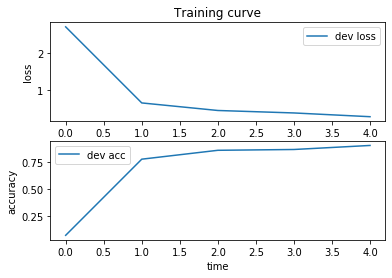

In [33]:
run_train(all_data, all_labels, backward_prop)